# Connectsionist Bench (Sonar, Mines vs. Rocks)

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from MachineLearningUtils.preprocessing_data import PreProcessingData
from MachineLearningUtils.svm_learning import SVMLearning
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, binarize
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
df = pd.read_csv('du lieu cung cap/sonar.all-data.txt', header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## Preprocessing data

*Xóa những feature chỉ có 1 giá trị*

In [5]:
df[60].value_counts()

M    111
R     97
Name: 60, dtype: int64

In [6]:
output_col = 60
ppd = PreProcessingData(df, 'classification')
print('Total null columns = ', ppd.get_null_column().shape[0])

Total null columns =  0


1. Dữ liệu có dạng ma trận thưa
2. Các Features có dạng nhị phân nhận 2 giá trị 0 và 1 => các cột có độ quan trọng tương đương nhau => không cần giảm số lượng features
3. Dữ liệu dự đoán có dạng category
4. Số mẫu dữ liệu dự đoán của mỗi category tương đối lơn => không cần resampling data
5. Dữ liệu không chưa missing data

=> Một số mô hình để dự đoán phù hơp có thể là: BernoulliNB, LogisticRegression

# Tiền xử lý dữ liệu

In [7]:
ppd = PreProcessingData(df, 'classification')

In [8]:
le = ppd.label_encode(output_col)
inputs = ppd.data.drop([output_col], axis=1)
output = ppd.data[output_col]

In [9]:
ppd.get_k_best_features_by_random_forest(output_col, 3)

11    0.088139
10    0.079348
52    0.035938
dtype: float64

In [10]:
ppd.get_k_best_features_by_extra_tree(output_col, 3)

8     0.059247
20    0.048019
36    0.039202
dtype: float64

## Sử dụng grid search với cv = 10 để chọn model thích hợp nhất với bộ dữ liệu

In [11]:
ppd.get_best_models(output_col, test_size=0.3)

,model_name,score_mean
0,LogisticRegression,0.825397
1,GaussianNB,0.777778
2,BernoulliNB,0.571429
3,MultinomialNB,0.777778
4,KNeighborsClassifier,0.841270
5,DecisionTreeClassifier,0.746032
6,RandomForestClassifier,0.785714
7,SVC,0.920635


Từ kết quả của kiểm tra các model ==> chọn SVC algorithms

### Đánh giá dữ liệu với SVC với kernel = linear

In [12]:
svc_linear_learning = SVMLearning(input_data=inputs, output_data=output, mode='classification', kernel='linear')
svc_linear_learning.train_test_split(test_size=0.3)
gscv = svc_linear_learning.get_best_params()
svc_linear_learning.build_model()

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [13]:
svc_linear_learning.best_params

{'C': 10,
 'gamma': 'scale',
 'kernel': 'linear',
 'probability': True,
 'random_state': 42}

In [14]:
svc_linear_learning.model.score(svc_linear_learning.X_train, svc_linear_learning.y_train), svc_linear_learning.model.score(svc_linear_learning.X_test, svc_linear_learning.y_test)

(0.8689655172413793, 0.8412698412698413)

### Đánh giá dữ liệu với SVC với kernel = poly

In [15]:
svc_poly_learning = SVMLearning(input_data=inputs, output_data=output, mode='classification', kernel='poly')
svc_poly_learning.train_test_split(test_size=0.3)
gscv = svc_poly_learning.get_best_params()
svc_poly_learning.build_model()

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma=1, kernel='poly',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [16]:
svc_poly_learning.best_params

{'C': 0.001,
 'degree': 4,
 'gamma': 1,
 'kernel': 'poly',
 'probability': True,
 'random_state': 42}

In [17]:
svc_poly_learning.model.score(svc_poly_learning.X_train, svc_poly_learning.y_train), svc_poly_learning.model.score(svc_poly_learning.X_test, svc_poly_learning.y_test)

(0.9517241379310345, 0.7936507936507936)

### Đánh giá dữ liệu với SVC với kernel = rbf

In [18]:
svc_rbf_learning = SVMLearning(input_data=inputs, output_data=output, mode='classification', kernel='rbf')
svc_rbf_learning.train_test_split(test_size=0.3)
gscv = svc_rbf_learning.get_best_params()
svc_rbf_learning.build_model()

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [19]:
svc_rbf_learning.best_params

{'C': 10, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 42}

In [20]:
svc_rbf_learning.model.score(svc_rbf_learning.X_train, svc_rbf_learning.y_train), svc_rbf_learning.model.score(svc_rbf_learning.X_test, svc_rbf_learning.y_test)

(1.0, 0.9206349206349206)

### Đánh giá dữ liệu với SVC với kernel = sigmoid

In [21]:
svc_sigmoid_learning = SVMLearning(input_data=inputs, output_data=output, mode='classification', kernel='sigmoid')
svc_sigmoid_learning.train_test_split(test_size=0.3)
gscv = svc_sigmoid_learning.get_best_params()
svc_sigmoid_learning.build_model()

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [22]:
svc_sigmoid_learning.best_params

{'C': 1000,
 'gamma': 0.01,
 'kernel': 'sigmoid',
 'probability': True,
 'random_state': 42}

In [24]:
svc_sigmoid_learning.model.score(svc_sigmoid_learning.X_train, svc_sigmoid_learning.y_train), svc_sigmoid_learning.model.score(svc_sigmoid_learning.X_test, svc_sigmoid_learning.y_test)

(0.8689655172413793, 0.8253968253968254)

Từ dữ kết quả chạy model => chọn SVC với C=10, gamma=1, kernel=rbf

### 1. Tạo X_train, X_test, y_train, y_test từ dữ liệu đã đọc và chuẩn hóa,với tỷ lệ dữ liệu test là 0.3

In [25]:
X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.3, random_state=42)

### 2. Chọn thuật toán xây dựng model

1. Do dữ liệu dự đoán là category nên chọn các thuật toán classifi
2. Từ dữ kết quả chạy model qua các thuật toán liên quan => chọn SVC
3. Sử dụng grid search => ta chọn được best params C=10, gamma=1, kernel=rbf

In [26]:
# from sklearn.svm import SVC

# connectsionist_model = SVC(
#     C= 10,
#     gamma= 1,
#     kernel= 'rbf',
#     probability= True,
#     random_state= 42)
# connectsionist_model.fit(X_train, y_train)

connectsionist_model = svc_rbf_learning.model

### 3. Đánh giá model

In [27]:
y_pred = connectsionist_model.predict(X_test)

In [28]:
print('Độ chính xác trên tập Train: ', connectsionist_model.score(X_train, y_train)*100, '%')
print('Độ chính xác trên tập Test: ', connectsionist_model.score(X_test, y_test)*100, '%')
print('Độ chính xác trên toàn dữ liệu: ', connectsionist_model.score(inputs, output)*100, '%')

Độ chính xác trên tập Train:  100.0 %
Độ chính xác trên tập Test:  92.06349206349206 %
Độ chính xác trên toàn dữ liệu:  97.59615384615384 %


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        35
           1       0.90      0.93      0.91        28

    accuracy                           0.92        63
   macro avg       0.92      0.92      0.92        63
weighted avg       0.92      0.92      0.92        63



In [30]:
print(confusion_matrix(y_test, y_pred))

[[32  3]
 [ 2 26]]


**Summary about the model:**
1. High precision: ~0.92, High recall: ~0.92
3. High training R^2 score: 1 and High testing score: ~92

=> The good model

### 4. Trực quan hóa kết quả dự đoán được từ model

In [31]:
# chọn column để trực quan hóa dữ liệu
ppd.get_k_best_features_by_extra_tree(output_col, 3)

8     0.059247
20    0.048019
36    0.039202
dtype: float64

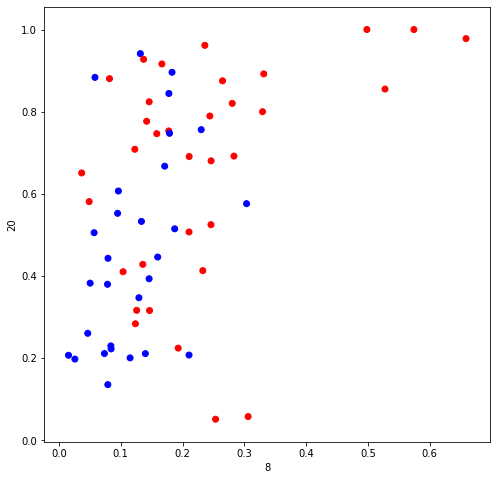

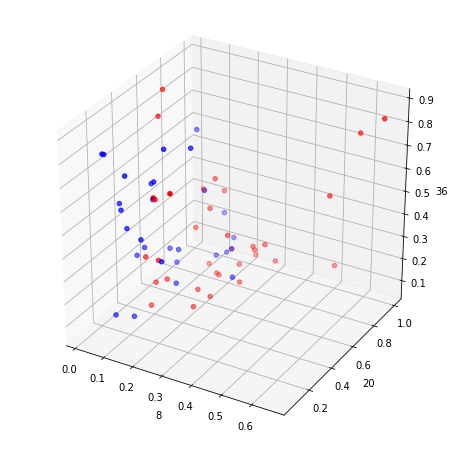

In [32]:
svc_rbf_learning.plot_scatter(8, 20)
svc_rbf_learning.plot_scatter(8, 20, 36)

1. Dữ liệu dự đoán trộn lẫn vào nhau khó phân biệt rõ ràng nếu số chiều dữ liệu nhỏ
2. Có một số điểm tách biệt với nhóm còn lại

### 5. Dựa trên kết quả, hãy cho biết nếu trong thành phần của món ăn có “cumin” và “fish” nhưng không có “yogurt” thì món ăn đó thường là món ăn của nước nào?

In [33]:
X_new = [[0.0123,0.0309,0.0169,0.0313,0.0358,0.0102,0.0182,0.0579,0.1122,0.0835,0.0548,0.0847,0.2026,0.2557,0.1870,0.2032,0.1463,0.2849,0.5824,0.7728,0.7852,0.8515,0.5312,0.3653,0.5973,0.8275,1.0000,0.8673,0.6301,0.4591,0.3940,0.2576,0.2817,0.2641,0.2757,0.2698,0.3994,0.4576,0.3940,0.2522,0.1782,0.1354,0.0516,0.0337,0.0894,0.0861,0.0872,0.0445,0.0134,0.0217,0.0188,0.0133,0.0265,0.0224,0.0074,0.0118,0.0026,0.0092,0.0009,0.0044],        [0.0203,0.0121,0.0380,0.0128,0.0537,0.0874,0.1021,0.0852,0.1136,0.1747,0.2198,0.2721,0.2105,0.1727,0.2040,0.1786,0.1318,0.2260,0.2358,0.3107,0.3906,0.3631,0.4809,0.6531,0.7812,0.8395,0.9180,0.9769,0.8937,0.7022,0.6500,0.5069,0.3903,0.3009,0.1565,0.0985,0.2200,0.2243,0.2736,0.2152,0.2438,0.3154,0.2112,0.0991,0.0594,0.1940,0.1937,0.1082,0.0336,0.0177,0.0209,0.0134,0.0094,0.0047,0.0045,0.0042,0.0028,0.0036,0.0013,0.0016]]

In [34]:
X_new_predict = le.inverse_transform(connectsionist_model.predict(X_new))

In [35]:
print('Dự đoán dựa trên dữ liệu 1:', X_new_predict[0])
print('Dự đoán dựa trên dữ liệu 2:', X_new_predict[1])

Dự đoán dựa trên dữ liệu 1: R
Dự đoán dựa trên dữ liệu 2: M
